In [78]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [5]:
#导入训练数据和测试数据
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

In [7]:
#查看一下训练数据的shape
train_df.shape

(1460, 80)

In [8]:
#前几行数据
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
#查看要预测的y值SalePrice的分布
prices = pd.DataFrame({"price":train_df['SalePrice'],"log(price+1)":np.log1p(train_df['SalePrice'])})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B6C2C62E8>,
      dtype=object)

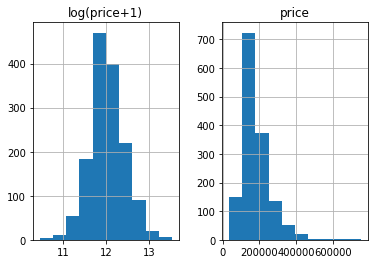

In [12]:
prices.hist()

In [13]:
#取出SalePrice列作为预测值，并进行平滑（正态化）
y_train = np.log1p(train_df.pop('SalePrice'))

In [14]:
#合并训练集和测试集数据
all_df = pd.concat((train_df, test_df), axis=0)

In [15]:
#查看整体数据集的shape
all_df.shape

(2919, 79)

In [16]:
#查看预测值的前几行
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

In [17]:
all_df['MSSubClass'].dtypes

dtype('int64')

In [18]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

In [19]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [20]:
all_df['MSSubClass'].dtypes

dtype('O')

In [21]:
pd.get_dummies(all_df['MSSubClass'], prefix='MMSubClass').head()

,MMSubClass_120,MMSubClass_150,MMSubClass_160,MMSubClass_180,MMSubClass_190,MMSubClass_20,MMSubClass_30,MMSubClass_40,MMSubClass_45,MMSubClass_50,MMSubClass_60,MMSubClass_70,MMSubClass_75,MMSubClass_80,MMSubClass_85,MMSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [22]:
all_dummy_df = pd.get_dummies(all_df)

In [23]:
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [24]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head()

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
dtype: int64

In [26]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']

In [27]:
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [28]:
numeric_cols_mean = all_dummy_df.loc[:,numeric_cols].mean()

In [29]:
numeric_cols_std = all_dummy_df.loc[:,numeric_cols].std()

In [30]:
all_dummy_df.loc[:,numeric_cols] = (all_dummy_df.loc[:,numeric_cols]-numeric_cols_mean)/numeric_cols_std

In [31]:
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,-0.934542,...,0,0,0,1,0,0,0,0,1,0
2,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,-0.629681,...,0,0,0,1,0,0,0,0,1,0
3,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,-0.288418,...,0,0,0,1,0,0,0,0,1,0
4,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,-0.047258,...,0,0,0,1,1,0,0,0,0,0
5,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,-0.161013,...,0,0,0,1,0,0,0,0,1,0


In [54]:
mean_cols = all_dummy_df.mean()

In [55]:
mean_cols.head(20)

LotFrontage    -2.040314e-16
LotArea         8.035234e-17
OverallQual     5.682334e-17
OverallCond     1.263502e-16
YearBuilt      -5.845121e-16
YearRemodAdd    7.849912e-16
MasVnrArea      3.091857e-16
BsmtFinSF1     -7.696988e-17
BsmtFinSF2      1.465966e-16
BsmtUnfSF       6.574590e-17
TotalBsmtSF     1.843396e-17
1stFlrSF       -1.130191e-16
2ndFlrSF        3.868095e-16
LowQualFinSF    7.604115e-16
GrLivArea       1.163091e-16
BsmtFullBath   -1.288726e-16
BsmtHalfBath    4.413489e-16
FullBath       -2.762816e-16
HalfBath        2.710329e-16
BedroomAbvGr    3.094286e-16
dtype: float64

In [61]:
all_dummy_df = all_dummy_df.fillna(mean_cols)

In [62]:
all_dummy_df.isnull().sum().sum()

0

In [63]:
train_df.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460],
           dtype='int64', name='Id', length=1460)

In [64]:
test_df.index

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919],
           dtype='int64', name='Id', length=1459)

In [65]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [66]:
dummy_train_df.shape

(1460, 303)

In [67]:
dummy_train_df['LotFrontage'].isnull().sum()

0

In [68]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values

In [69]:
X_train.shape

(1460, 303)

In [70]:
X_train.dtype

dtype('float64')

In [71]:
X_train.dtype

dtype('float64')

In [75]:
alphas = np.logspace(-3, 2, 50)
test_scores = []

In [76]:
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

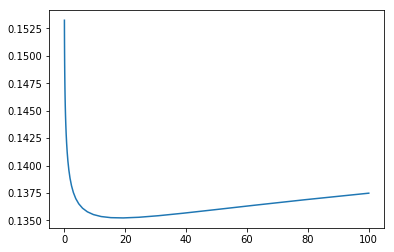

In [77]:
plt.plot(alphas, test_scores)

In [79]:
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []

In [80]:
for max_feature in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feature)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

In [81]:
test_scores

[0.1413583959396139,
 0.13771012677666236,
 0.13827976209539933,
 0.13928408319722788,
 0.1422082327778243,
 0.14253603095501408]

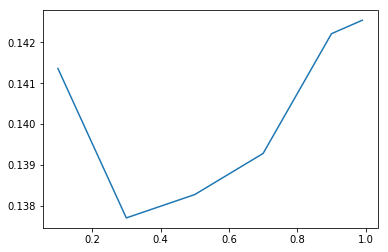

In [82]:
plt.plot(max_features, test_scores)

In [83]:
#最终模型
ridge = Ridge(alpha=15)
rf = RandomForestRegressor(n_estimators=500, max_features=.3)

In [84]:
ridge.fit(X_train, y_train)

Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [85]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [88]:
y_ridge = np.expm1(ridge.predict(X_test))

In [89]:
y_rf = np.expm1(rf.predict(X_test))

In [90]:
y_final = (y_ridge+y_rf)/2.0

In [91]:
data = pd.DataFrame({"id":test_df.index, 'SalePrice':y_final})

In [92]:
data.head()

,id,SalePrice
0,1461,119665.718650
1,1462,150285.670591
2,1463,175394.869789
3,1464,189222.549025
4,1465,195333.617394


In [93]:
data.to_csv('final.csv', index=0)